In [1]:
%matplotlib inline

In [2]:
import torch

import math
import random
import matplotlib.pyplot as plt

In [3]:
# generate a random Ising model
N = 20
J = torch.randint(0, 2, (N, N)) * 2 - 1.
h = torch.randint(0, 2, (N, 1)) * 2 - 1.
# symmetrize J
J = (J.T + J) / 2
J = J.fill_diagonal_(0.)

In [4]:
def bSB(J, h, init_x, init_y, init_a, init_b, num_iters, dt):
    N = J.shape[0]
    x_comp = init_x.clone()
    y_comp = init_y.clone()
    
    # scaling of the matrix.
    xi = 0.5 / J.square().sum().add_(h.square().sum()).div_(N).sqrt_()
    
    # pump rate is linearly increased from 0 to 1.
    ps = torch.linspace(0, 1, num_iters)
    
    energies = []
    for i in range(num_iters):
        y_comp += ((-1 + ps[i]) * x_comp + xi * (J @ x_comp + h * x_comp.abs().mean())) * dt
        x_comp += y_comp * dt

        y_comp[x_comp.abs() > 1] = 0.
        x_comp.clamp_(-1, 1)
        
        # compute the energy.
        sol = x_comp.sign()

        ################Trapping and correction####################
        # optimized_sol.
        threshold = 0.5
        opt_sol = sol.detach().clone()

        _threshold = threshold * x_comp.norm() / math.sqrt(N)
        swing_nodes_ids = torch.where(x_comp.abs() < _threshold)[0].tolist()

        random.shuffle(swing_nodes_ids)

        # Classify swing and trapped nodes
        opt_sol[swing_nodes_ids] = 0.

        # defrustrate swing nodes.
        for idx in swing_nodes_ids:
            spin = torch.sign(J[idx] @ opt_sol + h[idx] * opt_sol[idx])
            opt_sol[idx] = spin

        # trap swing nodes.
        order = list(range(N))
        random.shuffle(order)
        for idx in order:
            spin = torch.sign(J[idx] @ opt_sol + h[idx] * opt_sol[idx])
            # If it is zero, randomly assign one.
            if not spin:
                spin = random.randint(0, 1) * 2 - 1
            opt_sol[idx] = spin
        ################Trapping and correction####################

        # opt_sol is the solution obtained after the trapping and correction.
        e = - 1 / 2 * opt_sol.T @ J @ opt_sol - h.T @ opt_sol

        energies.append(e.item())
    
    return energies



In [5]:
# initialization of the Ising machine (SB/bSB)
init_x = torch.empty([N, 1]).uniform_(-0.1, 0.1)
init_y = torch.empty([N, 1]).uniform_(-0.1, 0.1)

# Additional states for the external fields
init_a = torch.empty([1, 1]).uniform_(-0.1, 0.1)
init_b = torch.empty([1, 1]).uniform_(-0.1, 0.1)

# parameters for the Ising machine (SB/bSB)
dt = 0.25
num_iters = 1000

# parameters for SB only.
M = 5

bsb_energies = bSB(J, h, init_x, init_y, init_a, init_b, num_iters, dt)

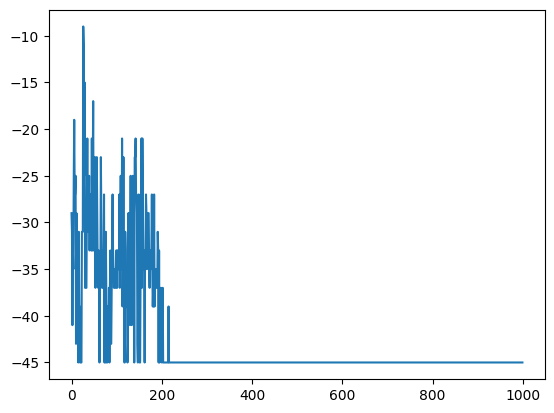

In [6]:
plt.plot(bsb_energies)